In [ ]:
from __future__ import annotations
import re
from collections import defaultdict
from typing import Dict, Any, List

import argparse
import sys
import time
from pathlib import Path
from collections import defaultdict
from typing import Any, Dict, List
from io import StringIO

from src.utils.po_fun_plot      import PO_plot# 
from src.utils.po_fun           import BasicUtils, StatisticalUtils, GenerationUtils
import os
from typing import Dict, Any, List, Mapping, Optional


import matplotlib.pyplot as plt  # noqa: F401 – reserved for future plots
import numpy as np
import pandas as pd
import yaml

# ────────────────────────────────────────────────────────────────────────────
# Project paths
# ────────────────────────────────────────────────────────────────────────────
try:
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
except NameError:  # interactive / ipython
    # Fallback for interactive use (adjust if your CWD isn't the script dir)
    PROJECT_ROOT = Path.cwd().parent # Assumes script is in a subdir like 'scripts' or 'notebooks'

SRC_DIR      = PROJECT_ROOT / "src"
CONFIG_DIR   = PROJECT_ROOT / "config"
DATA_DIR     = PROJECT_ROOT / "data"
RESULTS_DIR  = PROJECT_ROOT / "results"



# Ensure source directory is in Python path for imports
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
if str(SRC_DIR) not in sys.path: # Also add src dir if imports are relative to it
     sys.path.insert(0, str(SRC_DIR))

# ---------------------------------------------------------------------------
# Project‑specific imports (samplers)
# ---------------------------------------------------------------------------
try:
    # Adjust the import path based on your actual project structure
    # Assuming mcmc modules are directly under src/mcmc/
    from mcmc.hpo_po_hm_mcmc import mcmc_simulation_hpo
    from mcmc.hpo_po_hm_mcmc_k import mcmc_simulation_hpo_k
except ImportError as err:  # pragma: no cover
    # Provide more specific guidance if imports fail
    sys.exit(
        f"ERROR importing MCMC modules – check PYTHONPATH or project structure.\n"
        f"PROJECT_ROOT='{PROJECT_ROOT}', sys.path includes: '{SRC_DIR}'\n"
        f"Original error: {err}"
    )

# ---------------------------------------------------------------------------
# Config loader
# ---------------------------------------------------------------------------
DEFAULT_CONFIG_FILE = "hpo_mcmc_configuration.yaml"

def load_config(path: Path) -> Dict[str, Any]:
    """Loads configuration from a YAML file."""
    if not path.is_file():
        sys.exit(f"Config file not found: {path}")
    try:
        with path.open('r') as fh: # Specify read mode explicitly
            cfg = yaml.safe_load(fh)
    except yaml.YAMLError as err:
        sys.exit(f"YAML error parsing config file '{path}': {err}")
    except Exception as err: # Catch other potential file reading errors
        sys.exit(f"Error reading config file '{path}': {err}")

    if cfg is None: # Handle empty YAML file case
        print(f"WARNING: Config file '{path}' is empty or invalid, using defaults.")
        return {}
    print(f"Loaded config → {path}")
    return cfg


def load_data_from_files(
    base_dir: Path,
    item_chars_file: str = "item_characteristics.csv",
    rankings_file: str = "observed_rankings.csv",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Reads item characteristics and observed rankings CSVs,
    derives assessor and selective set information.
    """
    item_path = base_dir / item_chars_file
    rank_path = base_dir / rankings_file

    # ── items: handle potential blank lines robustly ───────────────────────

    # Read the CSV, skipping blank lines automatically
    items_df1 = pd.read_csv(item_path, comment='#', skip_blank_lines=False)
    assessors_df = pd.DataFrame()
    items_df = pd.DataFrame()
    # Drop rows where item_id is not numeric or is NaN
    # First find the first row where item_id equals 'assessor_id' 
    cutoff_idx = items_df1.loc[items_df1['item_id'] == 'assessor_id'].index
    if len(cutoff_idx) > 0:
        # Keep only rows before assessor_id appears
        items_df = items_df1.iloc[:cutoff_idx[0]]

# … earlier code …

    cutoff_idx2 = items_df1.loc[items_df1['item_id'] == 'selective_set_id'].index
    if len(cutoff_idx2) > 0:
        # → slice BETWEEN the two sentinel rows
        assessors_df = items_df1.iloc[cutoff_idx[0] : cutoff_idx2[0]].copy()
        selective_sets_df = items_df1.iloc[cutoff_idx2[0] :].copy()

        # ── NEW: treat first row as header ────────────────────────────────────
    if not assessors_df.empty:
        assessors_df.columns = assessors_df.iloc[0]          # promote row-0
        assessors_df = assessors_df.iloc[1:].reset_index(drop=True)

        # → drop columns that are entirely NaN (your trailing blank column)
        assessors_df = assessors_df.dropna(axis=1, how='all')


    if not selective_sets_df.empty:
        selective_sets_df.columns = selective_sets_df.iloc[0]          # promote row-0
        selective_sets_df = selective_sets_df.iloc[1:].reset_index(drop=True)

    # Clean up any remaining NaN rows
    items_df = items_df.dropna(how='all')
    assessors_df = assessors_df.dropna(how='all')
    selective_sets_df = selective_sets_df.dropna(how='all')
    print(selective_sets_df)

    # Convert item_id to numeric if possible
    items_df['item_id'] = pd.to_numeric(items_df['item_id'], errors='coerce')
    items_df = items_df.dropna(subset=['item_id'])
    print(assessors_df)
    rankings_df = pd.read_csv(rank_path, comment='#', skip_blank_lines=True)
    rankings_df.dropna(how='all', inplace=True)
    print(rankings_df.head())


    print(f"Loaded {len(items_df)} items, {len(assessors_df)} assessors, {len(rankings_df)} ranking observations.")
    return items_df, assessors_df,selective_sets_df, rankings_df

# ─────────────────────────────────────────────────────────────
# 1. Configure paths & options (edit if needed)
# ─────────────────────────────────────────────────────────────
current_dir  = Path.cwd()           # /…/hpo_inference/hpo_inference/notebooks
project_root = current_dir.parents[0]   # /…/hpo_inference
CONFIG_PATH   = project_root / "config" / "hpo_mcmc_configuration.yaml"
DATA_BASE     =  project_root /"data/generated_data"                # sub-directory with CSVs
ITEM_CHARS_FN = "item_characteristics.csv"
RANKINGS_FN   = "observed_rankings.csv"

USE_RJMCMC    = False    # set True for reversible-jump
SEED_OVERRIDE = None     # e.g. 12345 to fix the random seed


# ─────────────────────────────────────────────────────────────
# 2. Load configuration (YAML)
# ─────────────────────────────────────────────────────────────
cfg = load_config(CONFIG_PATH)
if SEED_OVERRIDE is not None:
    print(f"Overriding seed in config with {SEED_OVERRIDE}")
    cfg["random_seed"] = SEED_OVERRIDE

# ─────────────────────────────────────────────────────────────
# 3. Load raw CSV data
# ─────────────────────────────────────────────────────────────
items_df, assessors_df, selective_sets_df, rankings_df = load_data_from_files(
    DATA_BASE,
    ITEM_CHARS_FN,
    RANKINGS_FN,
)




# helper ────────────────────────────────────────────────────────────────────
_SPLIT_RE = re.compile(r"[;,]")          # comma *or* semicolon

def _parse_ids(s: str) -> List[int]:
    """Split '4,7,8' or '4;7;8' → [4, 7, 8] (keeps nothing empty)."""
    return [int(tok) for tok in _SPLIT_RE.split(str(s)) if tok.strip().isdigit()]

# main ──────────────────────────────────────────────────────────────────────
def prepare_mcmc_input_data(
    items_df: pd.DataFrame,
    assessors_df: pd.DataFrame,
    selective_sets_df: pd.DataFrame,     # still on the signature, but no longer used
    rankings_df: pd.DataFrame,
) -> Dict[str, Any]:
    """Turns the four CSV-derived frames into the dicts the MCMC code needs."""

    # ------------------------------------------------------------------ M0
    items = items_df["item_id"].astype(int).unique().tolist()

    # ------------------------------------------------------------------ X
    cov_cols = sorted(c for c in items_df.columns if c.startswith("covariate_"))
    X = items_df[cov_cols].apply(pd.to_numeric, errors="coerce").T.values  # (features × items)

    # ------------------------------------------------------------------ assessor list
    assessors = assessors_df["assessor_id"].astype(int).unique().tolist()

    # ------------------------------------------------------------------ dictionaries
    M_a_set         = defaultdict(set)     # will be turned into list later
    O_a_i_dict      = defaultdict(list)    # assessor → [choice-list, …]
    observed_orders = defaultdict(list)    # assessor → {ranking_id: ranking-list}

    for _, row in rankings_df.iterrows():
        aid = int(row["assessor_id"])

        # selective set for *this* task
        choice_items = _parse_ids(row["choice_set"])
        M_a_set[aid].update(choice_items)
        O_a_i_dict[aid].append(choice_items)

        # observed ranking for this task
        ranking_items = _parse_ids(row["observed_ranking"])
        observed_orders[aid].append(ranking_items)

    # finalise M_a_dict: assessor → sorted unique list
    M_a_dict = {aid: sorted(items) for aid, items in M_a_set.items()}

    print(
        f"Prepared data: |M0|={len(items)} items, |A|={len(assessors)} assessors, "
        f"Total choice-sets={sum(len(v) for v in O_a_i_dict.values())}"
    )

    return dict(
        M0=items,
        assessors=assessors,
        M_a_dict=M_a_dict,
        O_a_i_dict=O_a_i_dict,
        observed_orders=observed_orders,
        X=X,
    )

from __future__ import annotations
import sys
import time
from typing import Dict, Any


def run_mcmc(data: Dict[str, Any], cfg: Dict[str, Any], rjmcmc: bool = False) -> Dict[str, Any] | None:
    """Runs the appropriate MCMC simulation with parameters from config."""

    mcmc_cfg = cfg.get("mcmc", {})
    print(mcmc_cfg)
    noise_cfg = cfg.get("noise", {})
    prior_cfg = cfg.get("prior", {})
    rho_cfg = cfg.get("rho", {})  # Added for rho params
    rhotau_cfg = cfg.get("rhotau", {})  # Added for rhotau params
    beta_cfg = cfg.get("beta", {})  # Added for beta params

    # --- Parameter Extraction with Defaults --------------------------------
    num_iter = mcmc_cfg.get("num_iterations", 10000)
    if not isinstance(num_iter, int) or num_iter <= 0:
        print(
            f"WARNING: Invalid num_iterations ({num_iter}). Using default 10000.",
            file=sys.stderr,
        )
        num_iter = 10000

    # Use provided data structures directly
    common_args = dict(
        num_iterations=num_iter,
        M0=data.get("M0"),
        assessors=data.get("assessors"),
        M_a_dict=data.get("M_a_dict"),
        O_a_i_dict=data.get("O_a_i_dict"),
        observed_orders=data.get("observed_orders"),
        X=data.get("X"),
        # Priors
        sigma_beta=prior_cfg.get("sigma_beta", 0.5),
        rho_prior=prior_cfg.get("rho_prior", [1.0, 1.0]),  # Ensure float
        noise_beta_prior=prior_cfg.get("noise_beta_prior", 10.0),  # Ensure float
        mallow_ua=prior_cfg.get("mallow_ua", [0.1, 0.9]),
        # Noise model
        sigma_mallow=noise_cfg.get("sigma_mallow", 0.1),
        noise_option=noise_cfg.get("noise_option", "queue_jump"),
        # Step sizes / tuning params
        dr=rho_cfg.get("dr", 1.1),
        drrt=rhotau_cfg.get("drrt", 1.1),
        drbeta=beta_cfg.get("drbeta", 0.1),
        # Seed
        random_seed=cfg.get("random_seed", int(time.time() * 1000) % (2**32 - 1)),  # Ensure seed is valid
    )


    if rjmcmc:
        print(f"Running RJMCMC (Reversible Jump) for {num_iter} iterations…")
        # --- RJMCMC Specific Args -------------------------------------
        rjmcmc_pt_cfg = mcmc_cfg.get("update_probabilities", {})
        UPD_KEYS = [
            "rho",
            "tau",
            "rho_tau",
            "noise",
            "U_0",
            "U_a",
            "K",
            "beta",
        ]
        rjmcmc_pt = [float(rjmcmc_pt_cfg[k]) for k in UPD_KEYS]

        k_prior = prior_cfg.get("k_prior", 3)  # Prior on number of clusters
        common_args = dict(
            num_iterations=num_iter,
            M0=data.get("M0"),
            assessors=data.get("assessors"),
            M_a_dict=data.get("M_a_dict"),
            O_a_i_dict=data.get("O_a_i_dict"),
            observed_orders=data.get("observed_orders"),
            X=data.get("X"),
            # Priors
            sigma_beta=prior_cfg.get("sigma_beta", 0.5),
            rho_prior=prior_cfg.get("rho_prior", [1.0, 1.0]),  # Ensure float
            noise_beta_prior=prior_cfg.get("noise_beta_prior", 10.0),  # Ensure float
            mallow_ua=prior_cfg.get("mallow_ua", [0.1, 0.9]),
            # Noise model
            sigma_mallow=noise_cfg.get("sigma_mallow", 0.1),
            noise_option=noise_cfg.get("noise_option", "queue_jump"),
            mcmc_pt=rjmcmc_pt,
            # Step sizes / tuning params
            dr=rho_cfg.get("dr", 1.1),
            drrt=rhotau_cfg.get("drrt", 1.1),
            drbeta=beta_cfg.get("drbeta", 0.1),
            K_prior=k_prior,
            # Seed
            random_seed=cfg.get(
                "random_seed", int(time.time() * 1000) % (2**32 - 1)
            ),  # Ensure seed is valid
        )
        results = mcmc_simulation_hpo_k(**common_args)
    else:
        print(f"Running Fixed-K MCMC for {num_iter} iterations…")
        # --- Fixed-K Specific Args -----------------------------------
        fixed_k_pt_cfg = mcmc_cfg.get("update_probabilities", {})
        UPD_KEYS = [
            "rho",
            "tau",
            "rho_tau",
            "noise",
            "U_0",
            "U_a",
            "beta",
        ]
        fixed_k_pt = [float(fixed_k_pt_cfg[k]) for k in UPD_KEYS]
        common_args = dict(
            num_iterations=num_iter,
            M0=data.get("M0"),
            assessors=data.get("assessors"),
            M_a_dict=data.get("M_a_dict"),
            O_a_i_dict=data.get("O_a_i_dict"),
            observed_orders=data.get("observed_orders"),
            X=data.get("X"),
            K= mcmc_cfg.get("K", 3),
            # Priors
            sigma_beta=prior_cfg.get("sigma_beta", 0.5),
            rho_prior=prior_cfg.get("rho_prior", [1.0, 1.0]),  # Ensure float
            noise_beta_prior=prior_cfg.get("noise_beta_prior", 10.0),  # Ensure float
            mallow_ua=prior_cfg.get("mallow_ua", [0.1, 0.9]),
            # Noise model
            sigma_mallow=noise_cfg.get("sigma_mallow", 0.1),
            noise_option=noise_cfg.get("noise_option", "queue_jump"),
            mcmc_pt=fixed_k_pt,
            # Step sizes / tuning params
            dr=rho_cfg.get("dr", 1.1),
            drrt=rhotau_cfg.get("drrt", 1.1),
            drbeta=beta_cfg.get("drbeta", 0.1),
            # Seed
            random_seed=cfg.get(
                "random_seed", int(time.time() * 1000) % (2**32 - 1)
            ),  # Ensure seed is valid
        )
        results = mcmc_simulation_hpo(**common_args)

    return results




# ────────────────────────────────────────────────────────────────────────────
# Main analysis function
# ────────────────────────────────────────────────────────────────────────────

def analyze_results(
    results: Dict[str, Any],
    data: Dict[str, Any],
    config: Dict[str, Any],
    burn_in: Optional[int] = None,
    use_reversible_jump: bool = False,
) -> None:
    """High‑level post‑processing / diagnostics for an MCMC run.

    Parameters
    ----------
    results
        Dictionary returned by the sampler.
    data
        Prepared data dict (same one passed *into* the sampler).
    config
        Global YAML / dict configuration.
    use_reversible_jump
        Whether this was an RJMCMC run (affects diagnostics for K).
    """

    # ─────────────────────── sanity checks ────────────────────────────────
    if not results:
        print("ERROR: MCMC results dictionary is empty or None.")
        return

    analysis_cfg: Mapping[str, Any] = config.get("analysis", {})
    edge_threshold: float = float(analysis_cfg.get("edge_threshold", 0.5))
    top_n: int = int(analysis_cfg.get("top_partial_orders", 4))

    # output directory for all plots / artifacts
        # output directory for all plots / artifacts
    out_dir_raw = analysis_cfg.get("output_dir", "mcmc_output")
    out_dir: str = str(out_dir_raw or "mcmc_output")  # ensure not None/empty
    os.makedirs(out_dir, exist_ok=True)


    print("\n--- Analyzing MCMC Results ---")

    # ─────────────────────── log‑likelihood trace ─────────────────────────
    log_like = results.get("log_likelihood_currents", [])
    
    PO_plot.plot_log_likelihood(
        log_like, burn_in=burn_in)
    



    filtered_results = {
        key: trace[burn_in:] if isinstance(trace, np.ndarray) else trace
        for key, trace in mcmc_results.items()
    }
    # ─────────────────────── final partial‑order matrices -----------------
    h_trace = filtered_results.get("H_trace", [])


    assessors: List[int] = list(h_trace[0].keys())
    threshold: float = edge_threshold

    final_H = {}

    for aid in assessors:
        # gather this assessor's matrices over iterations
        matrices = [h_it[aid] for h_it in h_trace if aid in h_it]
        if not matrices:
            continue

        # mean presence of each edge
        mean_matrix = np.mean(matrices, axis=0)

        # count unique partial orders (for top‑n display)
        sorted_counts = StatisticalUtils.count_unique_partial_orders(matrices)
        total_samples = sum(cnt for _, cnt in sorted_counts)

        print(f"\nAssessor {aid}: total PO samples = {total_samples}")

        top_partial_orders = sorted_counts[:top_n]
        percentages = [
            (mat, cnt, (cnt / total_samples) * 100) for mat, cnt in top_partial_orders
        ]
        try:
            PO_plot.plot_top_partial_orders(
                percentages,
                top_n=top_n,
                item_labels=data.get("M0"),
                output_filename=os.path.join(out_dir, f"top_PO_a{aid}.png"),
            )
        except TypeError:
            PO_plot.plot_top_partial_orders(percentages, top_n=top_n, item_labels=data.get("M0"))

        # binarise & transitive reduction
        binary_matrix = (mean_matrix >= threshold).astype(int)
        final_H[aid] = BasicUtils.transitive_reduction(binary_matrix)

    # attach to results for downstream use
    results["H_final"] = final_H

    # ─────────────────────── parameter diagnostics ------------------------
    try:
        PO_plot.plot_inferred_variables(
            filtered_results,
            {
                "rho_true": config.get("rho_true"),
                "prob_noise_true": config.get("prob_noise_true"),
                "tau_true": config.get("tau_true"),
                "beta_true": config.get("beta_true"),
            },
            config,
            burn_in=0,
            output_filename=os.path.join(out_dir, "mcmc_inferred_variables.pdf"),
            assessors=data.get("assessors"),
            M_a_dict=data.get("M_a_dict"),
        )
    except Exception as e:  # broad except to avoid crashing post‑analysis
        print(f"(plot_inferred_variables failed: {e})")

    # optional extra plots --------------------------------------------------
    try:
        PO_plot.plot_beta_parameters(
            filtered_results,  # results after burn‑in
            {
                "beta_true": config.get("beta_true"),
            },
            config,
            burn_in=0,
            output_filename=os.path.join(out_dir, "beta_parameters.png"),
        )
    except Exception as e:
        print(f"(plot_beta_parameters failed: {e})")

    # latent‑space diagnostics (U₀ / U_a) -----------------------------------
    try:
        PO_plot.plot_u0_ua_diagnostics(
            results=filtered_results,
            assessors=data.get("assessors"),
            M0=data.get("M0"),
            K=config.get("mcmc", {}).get("K", 3),
            output_dir=out_dir,
        )
    except Exception as e:
        print(f"(plot_u0_ua_diagnostics failed: {e})")

    # global vs. inferred PO comparison ------------------------------------
    try:
        h_true_global = data.get("h_true_global")  # expected key
        if h_true_global is not None and 0 in final_H:
            PO_plot.compare_and_visualize_global(
                h_true_global,
                final_H[0],
                data.get("index_to_item"),
                [idx for idx in data.get("M0", [])],
                do_transitive_reduction=True,
                output_filename=os.path.join(out_dir, "global_PO_comparison.png"),
            )
    except Exception as e:
        print(f"(compare_and_visualize_global failed: {e})")

    # per‑assessor visualisation -------------------------------------------
    for aid in assessors:
        try:
            PO_plot.compare_and_visualize_assessor(
                aid,
                data.get("M_a_dict", {}).get(aid),
                data.get("h_true_a_dict", {}).get(aid),
                final_H.get(aid),
                data.get("index_to_item_local_dict", {}).get(aid),
                do_transitive_reduction=True,
                output_filename=os.path.join(out_dir, f"PO_comparison_a{aid}.png"),
            )
        except Exception as e:
            print(f"(Assessor {aid} comparison failed: {e})")

    # RJMCMC‑specific diagnostics -----------------------------------------
    if use_reversible_jump and "K_trace" in results:
        k_post = results["K_trace"][burn_in:]
        if k_post:
            k_counts = np.bincount(k_post)
            print(f"\nK posterior – mode: {k_counts.argmax()}, mean: {np.mean(k_post):.2f}")

    print("\n--- Analysis complete. Plots saved in:", os.path.abspath(out_dir))



prepared_data = prepare_mcmc_input_data(items_df, assessors_df, selective_sets_df, rankings_df)
mcmc_results = run_mcmc(prepared_data, cfg, rjmcmc=False)
analyze_results(mcmc_results, prepared_data, cfg,burn_in=6000, use_reversible_jump=False)



Loaded config → /home/doli/Desktop/research/coding/hpo_inference/config/hpo_mcmc_configuration.yaml
18 selective_set_id assessor_id          items
0                 1           1          7;4;8
1                 2           2  0;3;1;2;9;7;4
2                 3           3      2;4;6;1;0
3                 4           4  9;8;1;5;3;7;4
4                 5           5  9;8;4;3;5;7;2
11 assessor_id        name
0            1  Assessor_1
1            2  Assessor_2
2            3  Assessor_3
3            4  Assessor_4
4            5  Assessor_5
   ranking_id  assessor_id  task_id choice_set observed_ranking
0           1            1        1        4,7              7,4
1           2            1        2        7,8              7,8
2           3            1        3        7,8              7,8
3           4            1        4      4,7,8            7,4,8
4           5            1        5        7,8              7,8
Loaded 10 items, 5 assessors, 199 ranking observations.



--- Analyzing MCMC Results (PDF report) ---
Excluding 100 burn-in iterations


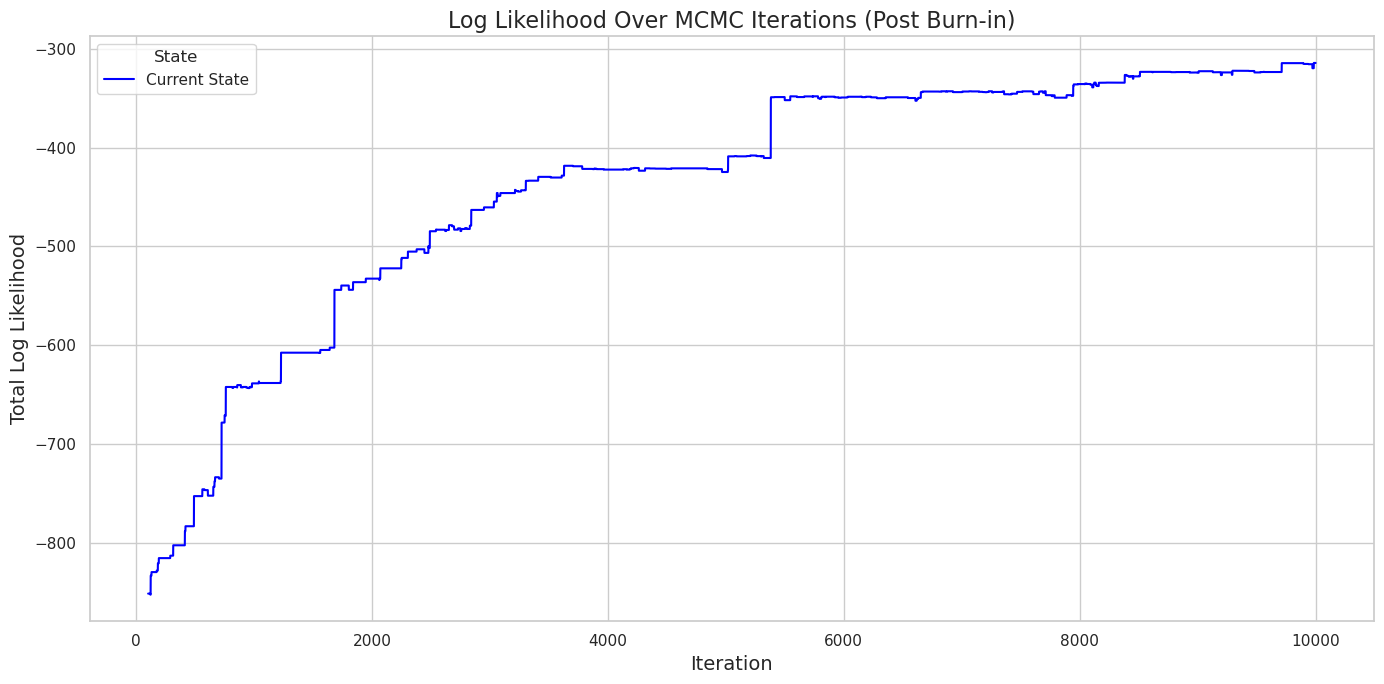

In [15]:
prepared_data = prepare_mcmc_input_data(items_df, assessors_df, selective_sets_df, rankings_df)
mcmc_results = run_mcmc(prepared_data, cfg, rjmcmc=False)
analyze_results(mcmc_results, prepared_data, cfg,burn_in=6000, use_reversible_jump=False)